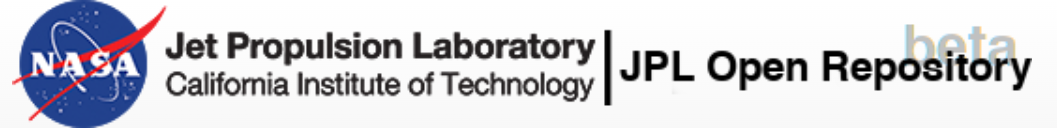

<b>Martian HiRISE Dataset</b>: https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA  
<br>
<b>About</b>: This dataset was created to study Mars' seasonal frost cycle and its role in the planet's climate and surface evolution over the past ~2 billion years. Scientists are interested in identifying low-latitude frosted microclimates and their impact on climate, and future exploration of Mars will partially depend on finding potential habitable environments and resources for human explorers. Previous studies of Mars' seasonal frost cycle were limited by a trade-off between coverage and spatial resolution, as scientists were forced to take either a global perspective using coarse observations or a local perspective focused on higher-resolution observations. To overcome this limitation, data science techniques could be useful to identify frost at a global scale with both high-resolution visible and coarse resolution thermal datasets. Toward that goal, models are needed to help identify frost in large-scale, high-resolution imagery. The dataset provided here is meant to address that need. It contains high resolution visible data (from HiRISE on MRO) with frost labels, which can be used to train machine learning models for frost identification in large datasets.

<b>Objective</b>: In this project, we are trying to build a classifier that distinguishes images of
Martian terrain with frost using CNN image classification and transfer learning algorithms (EfficientNetB0,
ResNet50, and VGG16)

In [1]:
# Checking if Google Colab detects the GPU.
import os
import shutil
import tensorflow as tf

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:    
    print(tf.config.experimental.get_device_details(gpu_devices[0]))
    print()

{'device_name': 'NVIDIA GeForce GTX 1650', 'compute_capability': (7, 5)}



In [2]:
from pathlib import Path
import numpy as np

In [3]:
IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size).
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory.
colab_folder = "../data"
data_head_dir = Path(colab_folder + '/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

<b><h2>Data Loading and Pre-processing</h2></b>

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets.
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names.
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        print(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [5]:
import random
from PIL import Image
import cv2

In [24]:
# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 8


<b>Data Augmentation</b>:
For Data Augmentation, 70% of the shuffled training set is selected, and one of the augmentations from 90 degree rotation, 180 degree rotation, 270 degree rotation, and horizontal image flip are performed randomly on each selected image.    



In [25]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        # Convert tensor to native type.
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        # Normalize the image to the [0, 1] range
        img = img / 255.0
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory.
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))
    return loc_list

def train_data_augmentation(augment_train_data):
  new_aug_list = []
  for i, img_data in enumerate(augment_train_data):
    imgpath_to_mod = augment_train_data[i][0]
    original_image = cv2.imread(imgpath_to_mod)
    random_number = np.random.randint(1, 5)
    # Apply different transformations based on the random number.
    if random_number == 1:
        # Rotate 90 degrees.
        modified_image = cv2.rotate(original_image, cv2.ROTATE_90_CLOCKWISE)
    elif random_number == 2:
        # Rotate 180 degrees.
        modified_image = cv2.rotate(original_image, cv2.ROTATE_180)
    elif random_number == 3:
        # Rotate 270 degrees.
        modified_image = cv2.rotate(original_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        # Flip the image (horizontal flip).
        modified_image = cv2.flip(original_image, 1)

    # Save the modified image to the augmented data location with the same name.
    temp = os.path.normpath(imgpath_to_mod).split(os.sep)
    temp[2] = "augmented_data"
    temp[-1] = temp[-1].split(".")[0] + "_modified." + temp[-1].split(".")[1]
    modified_image_path = os.path.join(*temp)

    new_aug_list.append((modified_image_path, augment_train_data[i][1]))
    aug_pth = os.path.normpath(modified_image_path).split(os.sep)[:-1]
    aug_pth = os.path.join(*aug_pth)
    if not os.path.exists(aug_pth):
        os.makedirs(aug_pth)
    cv2.imwrite(modified_image_path, modified_image)
  return new_aug_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

In [26]:
augment_folder_path = os.path.join(colab_folder, "augmented_data")
if os.path.exists(augment_folder_path):
    shutil.rmtree(augment_folder_path)
#os.makedirs(augment_folder_path)

# Shuffling Train set and segregatting into X & y.
random.shuffle(tf_data_train)
augment_train_data = tf_data_train[:int(0.7 * len(tf_data_train))]
new_aug_list = train_data_augmentation(augment_train_data)
tf_data_train.extend(new_aug_list)
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)


# Shuffling Validation set and segregatting into X & y.
random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)


# Shuffling Test set and segregatting into X & y.
random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

<b><h2>Building the CNN + MLP model Architecture</h2></b>

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

<b>Model Architecture</b>:  
The CNN + MLP architecture consists of 3 CNN layers and 1 Dense layer with L2 regularized penaly and a 30% dropout layer thereafter.

In [29]:
# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(299, 299, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layer with dropout and L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
adam_opt = Adam(learning_rate=0.00001)
model.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


# Train the model using tf.data.Dataset
history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])


Epoch 1/20
6307/6307 [==============================] - 777s 123ms/step - loss: 12.3439 - accuracy: 0.7657 - val_loss: 0.8041 - val_accuracy: 0.8575
Epoch 2/20
6307/6307 [==============================] - 758s 120ms/step - loss: 0.5368 - accuracy: 0.8385 - val_loss: 0.5147 - val_accuracy: 0.8083
Epoch 3/20
6307/6307 [==============================] - 738s 117ms/step - loss: 0.3956 - accuracy: 0.8741 - val_loss: 0.8372 - val_accuracy: 0.7414
Epoch 4/20
6307/6307 [==============================] - 741s 117ms/step - loss: 0.3469 - accuracy: 0.8954 - val_loss: 0.7596 - val_accuracy: 0.7712
Epoch 5/20
6307/6307 [==============================] - 738s 117ms/step - loss: 0.3097 - accuracy: 0.9130 - val_loss: 0.8612 - val_accuracy: 0.7214
Epoch 6/20
6307/6307 [==============================] - 826s 131ms/step - loss: 0.2895 - accuracy: 0.9219 - val_loss: 0.4569 - val_accuracy: 0.8463
Epoch 7/20
6307/6307 [==============================] - 748s 119ms/step - loss: 0.2709 - accuracy: 0.9313 - val

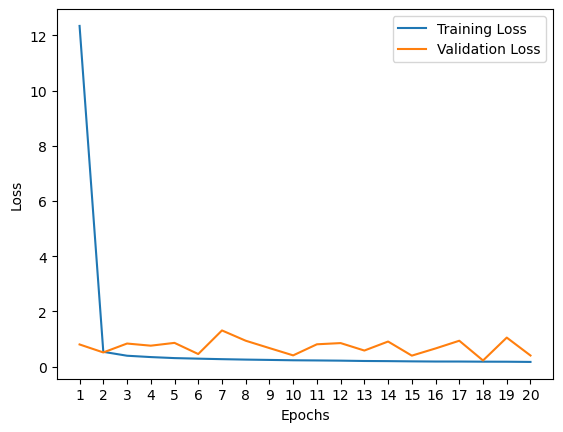

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([i for i in range(len(history.history['loss']))], [i for i in range(1, len(history.history['loss'])+1)])
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import classification_report

In [33]:
# Evaluate the model on the test set using tf.data.Dataset
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f'\nTest Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

model.save("./model_CNN_MLP.h5")

1603/1603 [==============================] - 117s 73ms/step - loss: 0.2149 - accuracy: 0.9481

Test Loss: 0.21487747132778168
Test Accuracy: 0.9481400847434998


In [34]:
# Predict on the test batch dataset.
def report_metrics(dataset_type, tf_dataset, i_model, model_name="CNN + MLP"):
  y_true = []
  y_pred_probs = []

  for batch in tf_dataset:
    X_batch, y_batch = batch
    y_true.extend(y_batch.numpy())
    
    # Make predictions
    batch_pred_probs = i_model.predict(X_batch, verbose=0)
    y_pred_probs.extend(batch_pred_probs)

  # Convert predicted probabilities to class labels
  y_pred_classes = np.argmax(y_pred_probs, axis=1)

  # Generate a classification report
  print(f'\nModel {model_name} Classification Report for {dataset_type} dataset:')
  print(classification_report(y_true, y_pred_classes))

In [35]:
report_metrics('Training', tf_dataset_train, model)
report_metrics('Validation', tf_dataset_val, model)
report_metrics('Testing', tf_dataset_test, model)


Model CNN + MLP Classification Report for Training dataset:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20776
           1       1.00      0.98      0.99     29678

    accuracy                           0.99     50454
   macro avg       0.99      0.99      0.99     50454
weighted avg       0.99      0.99      0.99     50454


Model CNN + MLP Classification Report for Validation dataset:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      7654
           1       0.74      0.99      0.85      3632

    accuracy                           0.89     11286
   macro avg       0.87      0.91      0.88     11286
weighted avg       0.91      0.89      0.89     11286


Model CNN + MLP Classification Report for Testing dataset:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4418
           1       0.95      0.97      0.96      8405

<b><h2>Building on the Transfer-Learning algorithms (EfficientNetB0, ResNet50, VGG16)</h2></b>

In [36]:
from keras import layers, models
from keras.applications import EfficientNetB0, ResNet50, VGG16

In [37]:
# Load pre-trained models.
base_model_efn = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model_rsn50 = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [38]:
# Freeze all layers in the base models.
for layer in base_model_efn.layers:
    layer.trainable = False

for layer in base_model_rsn50.layers:
    layer.trainable = False

for layer in base_model_vgg16.layers:
    layer.trainable = False

In [39]:
# Create a model for EfficientNetB0.
model_efn = models.Sequential([
    base_model_efn,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# Compile the model.
adam_opt = Adam(learning_rate=0.00001)
model_efn.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Create a model for ResNet50.
model_rsn50 = models.Sequential([
    base_model_rsn50,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# Compile the model.
adam_opt = Adam(learning_rate=0.00001)
model_rsn50.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Create a model for VGG16.
model_vgg16 = models.Sequential([
    base_model_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# Compile the model.
adam_opt = Adam(learning_rate=0.00001)
model_vgg16.compile(optimizer=adam_opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Train each model using the batch datasets.
models_list = [model_efn, model_rsn50, model_vgg16]
history_list = []

for i, model in enumerate(models_list):
    if i == 0:
      model_name = "EfficientNetB0"
    elif i == 1:
      model_name = "ResNet50"
    else:
      model_name = "VGG16"
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    print("\n========== Model Training for {} ==========\n\n".format(model_name))
    history = model.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping])
    history_list.append(history)


========== Model Training for EfficientNetB0 ==========


Epoch 1/15
6307/6307 [==============================] - 736s 115ms/step - loss: 0.7307 - accuracy: 0.5351 - val_loss: 0.6429 - val_accuracy: 0.6934
Epoch 2/15
6307/6307 [==============================] - 704s 111ms/step - loss: 0.7082 - accuracy: 0.5560 - val_loss: 0.6183 - val_accuracy: 0.6782
Epoch 3/15
6307/6307 [==============================] - 724s 115ms/step - loss: 0.7010 - accuracy: 0.5589 - val_loss: 0.9433 - val_accuracy: 0.3218
Epoch 4/15
6307/6307 [==============================] - 711s 113ms/step - loss: 0.6969 - accuracy: 0.5642 - val_loss: 0.6649 - val_accuracy: 0.7730
Epoch 5/15
6307/6307 [==============================] - 712s 113ms/step - loss: 0.6919 - accuracy: 0.5647 - val_loss: 0.9226 - val_accuracy: 0.3218
Epoch 6/15
6307/6307 [==============================] - 708s 112ms/step - loss: 0.6882 - accuracy: 0.5689 - val_loss: 0.7814 - val_accuracy: 0.3218
Epoch 7/15
6307/6307 [==============================]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6307/6307 [==============================] - 1594s 253ms/step - loss: 0.2863 - accuracy: 0.8764 - val_loss: 0.5029 - val_accuracy: 0.7760
Epoch 8/15
6307/6307 [==============================] - 1658s 263ms/step - loss: 0.2763 - accuracy: 0.8816 - val_loss: 0.5083 - val_accuracy: 0.7754
Epoch 9/15
6307/6307 [==============================] - 1615s 256ms/step - loss: 0.2653 - accuracy: 0.8877 - val_loss: 0.5023 - val_accuracy: 0.7838
Epoch 10/15
2998/6307 [=============>................] - ETA: 11:41 - loss: 0.2592 - accuracy: 0.8899

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6307/6307 [==============================] - 1620s 257ms/step - loss: 0.2558 - accuracy: 0.8913 - val_loss: 0.4982 - val_accuracy: 0.7847
Epoch 11/15
6307/6307 [==============================] - 1606s 254ms/step - loss: 0.2488 - accuracy: 0.8949 - val_loss: 0.5241 - val_accuracy: 0.7788
Epoch 12/15
6307/6307 [==============================] - 1600s 254ms/step - loss: 0.2423 - accuracy: 0.8995 - val_loss: 0.4649 - val_accuracy: 0.8062
Epoch 13/15
6307/6307 [==============================] - 1612s 256ms/step - loss: 0.2386 - accuracy: 0.9004 - val_loss: 0.4672 - val_accuracy: 0.8068
Epoch 14/15
6307/6307 [==============================] - 1733s 275ms/step - loss: 0.2295 - accuracy: 0.9044 - val_loss: 0.4682 - val_accuracy: 0.8095
Epoch 15/15
6307/6307 [==============================] - 1619s 257ms/step - loss: 0.2308 - accuracy: 0.9053 - val_loss: 0.4627 - val_accuracy: 0.8116


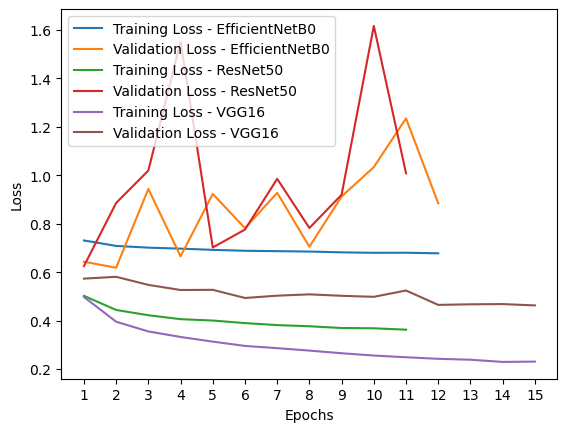

In [44]:
# Plot training history
max_epoch_len = 0
for i, history in enumerate(history_list):
    if i == 0:
      model_name = "EfficientNetB0"
    elif i == 1:
      model_name = "ResNet50"
    else:
      model_name = "VGG16"
    plt.plot(history.history['loss'], label=f'Training Loss - {model_name}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - {model_name}')
    if len(history.history['loss']) > max_epoch_len:
      max_epoch_len = len(history.history['loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([i for i in range(max_epoch_len)], [i for i in range(1, max_epoch_len+1)])
plt.legend()
plt.show()

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Evaluate each model on the test set
for i, model in enumerate(models_list):
    if i == 0:
      model_name = "EfficientNetB0"
    elif i == 1:
      model_name = "ResNet50"
    else:
      model_name = "VGG16"

    test_loss, test_accuracy = model.evaluate(tf_dataset_test)
    print(f'Model {model_name} - Test Loss: {test_loss}')
    print(f'Model {model_name} - Test Accuracy: {test_accuracy}')
    try:
        model.save("./model_{}.h5".format(model_name))
    except:
        print("\nNote: Unable to save the {} model at the moment due to tensorflow version compatibility issue.\nSkipping the model saving process for now.".format(model_name))

    # Make predictions
    report_metrics('Training', tf_dataset_train, model, model_name=model_name)
    report_metrics('Validation', tf_dataset_val, model, model_name=model_name)
    report_metrics('Testing', tf_dataset_test, model, model_name=model_name)

1603/1603 [==============================] - 247s 153ms/step - loss: 0.8055 - accuracy: 0.3445
Model EfficientNetB0 - Test Loss: 0.8054841160774231
Model EfficientNetB0 - Test Accuracy: 0.3445371687412262

Note: Unable to save the EfficientNetB0 model at the moment due to tensorflow version compatibility issue.
Skipping the model saving process for now.

Model EfficientNetB0 Classification Report for Training dataset:
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     20776
           1       0.00      0.00      0.00     29678

    accuracy                           0.41     50454
   macro avg       0.21      0.50      0.29     50454
weighted avg       0.17      0.41      0.24     50454


Model EfficientNetB0 Classification Report for Validation dataset:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy       

<b><h2>Result comparision of CNN+MLP, EfficientNetB0, ResNet50, and VGG16 algorithms</h2></b>  

<b><h4>1) Test result obtained for the CNN + MLP architecture:</h4></b>   
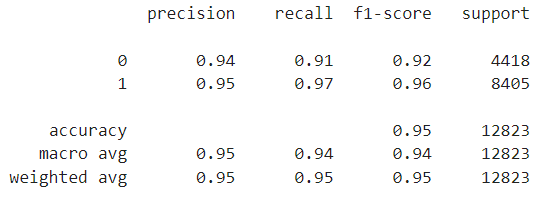
    

<b><h4>2) Test result obtained for the EfficientNetB0 architecture:</h4></b>    
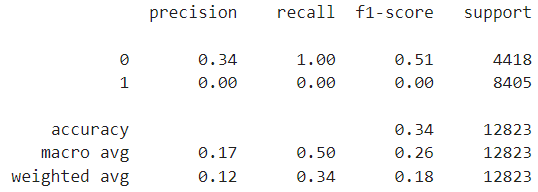
    

<b><h4>3) Test result obtained for the ResNet50 architecture:</h4></b>    
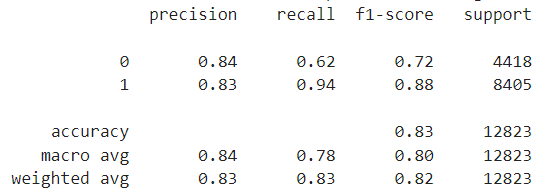
    

<b><h4>4) Test result obtained for the VGG16 architecture:</h4></b>     
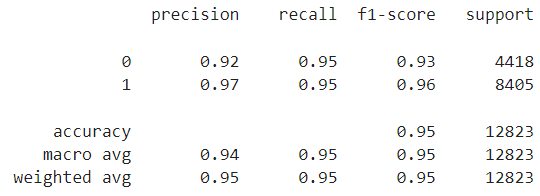

<b>Understanding the results:</b>    
1) The CNN+MLP and VGG16 architectures perform the best with test accuracy of <b>95%</b>. The weighted avg Precision value of <b>0.95</b> for both models tells us that, out of all positively predicted class, 95% of them are predicted correctly. Similarly for weighted avg Recall value of <b>0.95</b> for both models tells us that, out of all actual positive class, 95% were correctly predicted. For both of these models, we get an f1-score of <b>95%</b>, which is the harmonic mean of precision and recall values.   
<br>   
2) ResNet50 is our second best performing model architecture with accuracy of <b>83%</b>. And Precision, Recall, and F1-score values as 0.83, 0.83, and 0.82 respectively.    
<br>    
3) The EfficientNet50 architecture performs poorly on the dataset, as it is only able to classify the 0 class.
<br>
4) As a final verdict, we can rely more on the CNN+MLP and VGG16 models in this case as their scores and plots have shown us steady results as compared to other 2 models.

<center>========== Project End ==========</center>